# Neurophysiology and Biophysics - Practical course 2022/23

Cornelia Kopp-Scheinpflug, Kay Thurley


__Miniproject: Gap junctions__


In this notebook we investigate the emergence of oscillations in neurons coupled by gap junctions. For the simulations we use a model of rat hippocampal CA1 neuron and include axo-axonal electrical coupling (gap junctions).

We use the model by Vladimirov et al. 2012 published on ModelDB. Converted to Python by Kay Thurley (2022).


_Requirements:_ You will need Neuron 8, Python 3 and the packages Matplotlib for plotting and Numpy for mathematical functions and array handling.


We start by importing the relevant packages.

In [28]:
# import Neuron's hoc interpreter
from neuron import h
h.load_file('stdrun.hoc')

# set default units
from neuron.units import ms, mV

import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

Then we define the model neuron by loading a morphology file and files with the relevant mechanisms.

In [29]:
# load the morphology and cell biophysics
h.load_file('cellTemplate.hoc')
h.load_file('gapjunction.hoc')
# h.load_file('init_2cells.hoc')

# create pyramidal neurons
dc_bias = -0.1
ncells = 2
cells = h.List()
for i in range(ncells):
    cell = h.pyramidal()
    
    # set position of the cell
    x = (i+1)*1000.
    y = (i+1)*0.
    cell.position(x, y, 0)
    cell.setgid(i)
    
    # add constant current to soma
    # current is in nA, "-" for hyperpolarizing, "+" for depolarizing
    area_soma = np.pi*cell.soma.diam*cell.soma.L*1e-8
    cell.soma.insert('bias')
    cell.soma(0.5).bias.amp = -dc_bias * 1e-6/area_soma
    
    cells.append(cell)

# access the pyramidal neurons
pyrA = cells[0]
pyrB = cells[1]

print(pyrA)
print(pyrB)


# simulation paramters
h.tstop = 15
h.dt = 0.025
h.v_init = -65

pyramidal[4]
pyramidal[5]


In [30]:
h.load_file('my_connection.hoc')

1.0

In [31]:
# add gap junction
gj_conductance = 0.003      # [mS]

# position of gj in axonal sections:
axonal_section1 = 10   # section index in cell[1].axon[]
axonal_section2 = 10   # section index in cell[2].axon[]
section1_pos = 0.5    # position within section1
section2_pos = 0.5    # position within section2
gap = h.gapjunction(pyrA, axonal_section1, pyrB, axonal_section2, gj_conductance, section1_pos, section2_pos)

To check, how the compartments are named, call `h('forall print secname()')` or use `h.topology()` for a bit more insight into the morphological structure of the neuron(s).

Let's plot the morphology.

In [32]:
# ps = h.PlotShape(True)

# # get matplotlib plotshape with default coloring (for v)
# ps = h.PlotShape(False).plot(plt)

# # highlight the apical dendrite
# ps._do_plot(0, 1, h.dend, None, color='red')

Add the stimulation.

In [38]:
num_pulses = 1
inter_stim_interval = 5

stim = h.List()
for i in range(num_pulses):
    stim.append(h.IClamp(0.5, sec=pyrA.soma))
    stim[i].amp = 0
    stim[i].delay = 5 + inter_stim_interval * i
    stim[i].dur = 1

Recording settings.

In [39]:
# vectors to store data
t_vec = h.Vector()                  # Time stamp vector
t_vec.record(h._ref_t)

v_pyrA = h.Vector()                 # membrane potential vector for first pyramidal cell
v_pyrB = h.Vector()                 # membrane potential vector for second pyramidal cell


# v_pyrA.record(pyrA.soma(0.5)._ref_v)
# v_pyrB.record(pyrB.soma(0.5)._ref_v)
v_pyrA.record(pyrA.axon[axonal_section1](section1_pos)._ref_v)
v_pyrB.record(pyrB.axon[axonal_section2](section2_pos)._ref_v)
# note that the voltage is recorded in the axon

# record stimuli
istim = h.List()
for i in range(0, num_pulses):
    istim.append(h.Vector())
    istim[i].record(stim[i]._ref_i)

In [40]:
# for x in pyrA.axon[axonal_section1].psection()['point_processes']['Gap']:
#     print(x.g)
# gj_conductance = 0.001
# gap.setg(gj_conductance)
# for x in pyrA.axon[axonal_section1].psection()['point_processes']['Gap']:
#     print(x.g)

Let's run the simulation.

In [41]:
h.init()
print('running simulation ...')
h.run()

running simulation ...


0.0

Plot the results.

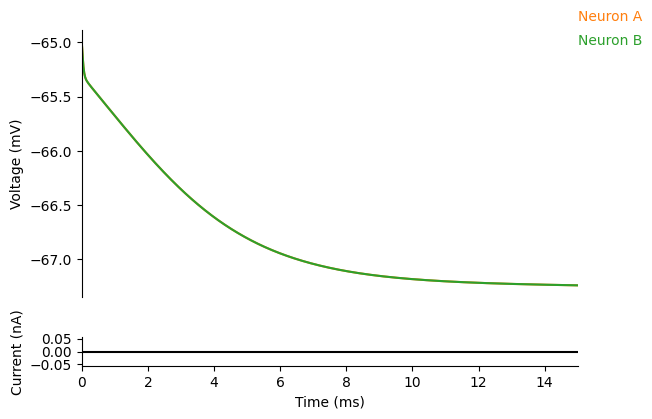

In [42]:
fig = plt.figure()
gs = gridspec.GridSpec(11, 2)

# voltage axis
ax1 = fig.add_subplot(gs[0:8, :])
ax1.plot(t_vec, v_pyrA, '-', color='C01')
ax1.plot(t_vec, v_pyrB, '-', color='C02')
max_v = max(v_pyrA.max(), v_pyrB.max())
fig.text(.9, .9, "Neuron A", color='C01')
fig.text(.9, .85, "Neuron B", color='C02')
ax1.set_ylabel('Voltage ('+h.units('v')+')')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim([0, h.tstop])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# current axis
ax2 = fig.add_subplot(gs[9:10, :], sharex=ax1)
for i in range(num_pulses):
    ax2.plot(t_vec, istim[i], '-', color='k')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylabel('Current (nA)')
ax2.set_xlabel('Time ('+h.units('t')+')')
ax2.set_xlim([0, h.tstop])

plt.show()